## Test on certain functions from `SurvivalLVQ.py`

In [10]:
import torch
import numpy as np
from SurvivalLVQ import SurvivalLVQ
from sksurv.util import Surv
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("SurvivalLVQ Test Example")

SurvivalLVQ Test Example


In [11]:
# Generate synthetic survival data
n_samples = 100
n_features = 4

# Generate random features
X = np.random.randn(n_samples, n_features)

# Generate survival times and event indicators
# Higher feature values lead to higher risk (shorter survival)
risk_score = X[:, 0] + 0.5 * X[:, 1] - 0.3 * X[:, 2] + 0.2 * X[:, 3]
baseline_hazard = 0.01
survival_times = np.random.exponential(1 / (baseline_hazard * np.exp(risk_score)))

# Add censoring (30% censored)
censoring_times = np.random.exponential(50, n_samples)
observed_times = np.minimum(survival_times, censoring_times)
event_indicator = survival_times <= censoring_times

print(f"Dataset: {n_samples} samples, {n_features} features")
print(f"Event rate: {event_indicator.mean():.2%}")
print(f"Mean survival time: {observed_times.mean():.2f}")
print(f"Time range: [{observed_times.min():.2f}, {observed_times.max():.2f}]")


Dataset: 100 samples, 4 features
Event rate: 32.00%
Mean survival time: 28.76
Time range: [0.45, 201.93]


In [12]:
# Create structured array for scikit-survival format
y = Surv.from_arrays(event_indicator, observed_times)

print("Survival data structure:")
print(f"y shape: {y.shape}")
print(f"First 5 samples:")
for i in range(5):
    status = "Event" if y[i][0] else "Censored"
    print(f"  Sample {i+1}: {status} at time {y[i][1]:.2f}")


Survival data structure:
y shape: (100,)
First 5 samples:
  Sample 1: Censored at time 31.04
  Sample 2: Event at time 62.51
  Sample 3: Censored at time 1.87
  Sample 4: Censored at time 14.55
  Sample 5: Censored at time 62.47


In [13]:
# Initialize and train the SurvivalLVQ model
model = SurvivalLVQ(
    n_prototypes=3,
    n_omega_rows=None,  # Use full rank
    batch_size=32,
    init='kmeans',
    device=torch.device("cpu"),
    lr=1e-3,
    epochs=20,
    verbose=True
)

print("Training SurvivalLVQ model...")
print("-" * 30)
model.fit(X, y)


Training SurvivalLVQ model...
------------------------------
Epoch: 1 / 20 | Loss: 0.144998
Epoch: 2 / 20 | Loss: 0.132699
Epoch: 3 / 20 | Loss: 0.143034
Epoch: 4 / 20 | Loss: 0.143832
Epoch: 5 / 20 | Loss: 0.134232
Epoch: 6 / 20 | Loss: 0.143831
Epoch: 7 / 20 | Loss: 0.145242
Epoch: 8 / 20 | Loss: 0.142809
Epoch: 9 / 20 | Loss: 0.143818
Epoch: 10 / 20 | Loss: 0.153083
Epoch: 11 / 20 | Loss: 0.144140
Epoch: 12 / 20 | Loss: 0.128914
Epoch: 13 / 20 | Loss: 0.132565
Epoch: 14 / 20 | Loss: 0.138536
Epoch: 15 / 20 | Loss: 0.137732
Epoch: 16 / 20 | Loss: 0.137667
Epoch: 17 / 20 | Loss: 0.147097
Epoch: 18 / 20 | Loss: 0.145837
Epoch: 19 / 20 | Loss: 0.136951
Epoch: 20 / 20 | Loss: 0.133143


SurvivalLVQ()

In [19]:
# Test the forward method (risk scores)
print("\n" + "=" * 50)
print("TESTING FORWARD METHOD (Risk Scores)")
print("=" * 50)

# Test with a few sample patients
test_patients = torch.tensor([
    [0.5, 1.2, 0.8, 1.1],  # Patient 1
    [1.0, 0.7, 1.5, 0.9],  # Patient 2
    [0.3, 1.8, 0.4, 1.3],  # Patient 3
    [-1.0, -0.5, 2.0, 0.5] # Patient 4
])

risk_scores = model.forward(test_patients)
print(f"Risk scores (negative normalized area under survival curve):")
for i, score in enumerate(risk_scores):
    print(f"  Patient {i+1}: {score:.4f}")

print(f"\nInterpretation:")
print(f"- More negative = better prognosis (longer expected survival)")
print(f"- Less negative = worse prognosis (shorter expected survival)")



TESTING FORWARD METHOD (Risk Scores)
Risk scores (negative normalized area under survival curve):
  Patient 1: -0.6274
  Patient 2: -0.5988
  Patient 3: -0.6288
  Patient 4: -0.6267

Interpretation:
- More negative = better prognosis (longer expected survival)
- Less negative = worse prognosis (shorter expected survival)


In [15]:
# Test predict_curves method
print("\n" + "=" * 50)
print("TESTING PREDICT_CURVES METHOD")
print("=" * 50)

predicted_curves = model.predict_curves(test_patients)
print(f"Predicted survival curves shape: {predicted_curves.shape}")
print(f"(patients, timepoints): ({predicted_curves.shape[0]}, {predicted_curves.shape[1]})")

print(f"\nTimepoints: {model.timepoints.numpy()[:10]}...")  # Show first 10 timepoints
print(f"Full survival curves for each patient:")

for i in range(len(test_patients)):
    print(f"\nPatient {i+1} survival probabilities:")
    curve = predicted_curves[i]
    # Show survival at key timepoints
    key_indices = [0, len(curve)//4, len(curve)//2, 3*len(curve)//4, -1]
    for idx in key_indices:
        time = model.timepoints[idx].item()
        prob = curve[idx].item()
        print(f"  t={time:.1f}: S(t)={prob:.3f}")
    
    # Calculate area under curve manually to verify forward method
    area = torch.trapezoid(curve, model.timepoints).item()
    normalized_area = area / model.timepoints.max().item()
    print(f"  Area under curve: {area:.2f}")
    print(f"  Normalized area: {normalized_area:.4f}")
    print(f"  Forward method result: {risk_scores[i]:.4f} (should be -{normalized_area:.4f})")



TESTING PREDICT_CURVES METHOD
Predicted survival curves shape: torch.Size([4, 32])
(patients, timepoints): (4, 32)

Timepoints: [0.45192876 0.7538064  0.8224654  1.0917126  1.5561666  4.4715095
 4.681487   5.051338   5.576544   5.8684278 ]...
Full survival curves for each patient:

Patient 1 survival probabilities:
  t=0.5: S(t)=1.000
  t=5.6: S(t)=0.879
  t=8.0: S(t)=0.815
  t=23.7: S(t)=0.659
  t=82.8: S(t)=0.467
  Area under curve: 51.93
  Normalized area: 0.6274
  Forward method result: -0.6274 (should be -0.6274)

Patient 2 survival probabilities:
  t=0.5: S(t)=1.000
  t=5.6: S(t)=0.882
  t=8.0: S(t)=0.803
  t=23.7: S(t)=0.637
  t=82.8: S(t)=0.420
  Area under curve: 49.56
  Normalized area: 0.5988
  Forward method result: -0.5988 (should be -0.5988)

Patient 3 survival probabilities:
  t=0.5: S(t)=1.000
  t=5.6: S(t)=0.879
  t=8.0: S(t)=0.815
  t=23.7: S(t)=0.660
  t=82.8: S(t)=0.469
  Area under curve: 52.05
  Normalized area: 0.6288
  Forward method result: -0.6288 (should be 


PLOTTING SURVIVAL CURVES


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

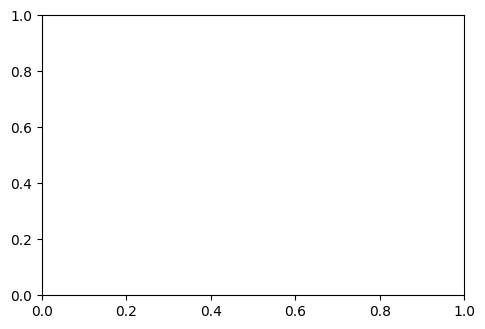

In [18]:
# Plot survival curves
print("\n" + "=" * 50)
print("PLOTTING SURVIVAL CURVES")
print("=" * 50)

plt.figure(figsize=(12, 8))

# Plot predicted survival curves for test patients
plt.subplot(2, 2, 1)
for i in range(len(test_patients)):
    plt.plot(model.timepoints.numpy(), predicted_curves[i].numpy(), 
             label=f'Patient {i+1} (risk: {risk_scores[i]:.3f})', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Predicted Survival Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot prototype survival curves
plt.subplot(2, 2, 2)
for i in range(model.n_prototypes):
    plt.plot(model.timepoints.numpy(), model.c[i, :].detach().numpy(), 
             label=f'Prototype {i+1}', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Prototype Survival Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot feature relevances
plt.subplot(2, 2, 3)
relevance_matrix = model.lambda_mat().detach().numpy()
feature_relevances = np.diag(relevance_matrix)
plt.bar(range(len(feature_relevances)), feature_relevances)
plt.xlabel('Feature Index')
plt.ylabel('Relevance')
plt.title('Feature Relevances')
plt.xticks(range(len(feature_relevances)))
plt.grid(True, alpha=0.3)

# Plot relevance matrix heatmap
plt.subplot(2, 2, 4)
im = plt.imshow(relevance_matrix, cmap='viridis')
plt.colorbar(im)
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Relevance Matrix')

plt.tight_layout()
plt.show()


In [17]:
# Test model evaluation on training data
print("\n" + "=" * 50)
print("MODEL EVALUATION")
print("=" * 50)

# Calculate Brier score on training data
brier_score = model.loss_brier(model.datapoints)
print(f"Brier Score (lower is better): {brier_score:.4f}")

# Test predict method (risk scores for sklearn compatibility)
risk_predictions = model.predict(X[:10])  # Test on first 10 samples
print(f"\nRisk predictions for first 10 training samples:")
for i, risk in enumerate(risk_predictions):
    event_status = "Event" if y[i][0] else "Censored"
    print(f"  Sample {i+1}: Risk={risk:.4f}, Actual={event_status} at t={y[i][1]:.2f}")

# Test closest prototype assignment
closest_prototypes = model.predict(X[:10], closest=True)
print(f"\nClosest prototype assignments for first 10 samples:")
for i, proto in enumerate(closest_prototypes):
    print(f"  Sample {i+1}: Closest to Prototype {proto+1}")

print(f"\nModel Summary:")
print(f"- Number of prototypes: {model.n_prototypes}")
print(f"- Number of features: {model.n_features}")
print(f"- Number of timepoints: {model.n_timepoints}")
print(f"- Device: {model.device}")
print(f"- Omega matrix shape: {model.omega.shape}")
print(f"- Prototype matrix shape: {model.w.shape}")
print(f"- Label matrix shape: {model.c.shape}")



MODEL EVALUATION
Brier Score (lower is better): 0.0446

Risk predictions for first 10 training samples:
  Sample 1: Risk=-0.6374, Actual=Censored at t=31.04
  Sample 2: Risk=-0.6351, Actual=Event at t=62.51
  Sample 3: Risk=-0.6504, Actual=Censored at t=1.87
  Sample 4: Risk=-0.6128, Actual=Censored at t=14.55
  Sample 5: Risk=-0.6503, Actual=Censored at t=62.47
  Sample 6: Risk=-0.5510, Actual=Censored at t=112.79
  Sample 7: Risk=-0.6798, Actual=Censored at t=35.84
  Sample 8: Risk=-0.6846, Actual=Censored at t=37.98
  Sample 9: Risk=-0.5649, Actual=Censored at t=5.67
  Sample 10: Risk=-0.6050, Actual=Censored at t=29.66

Closest prototype assignments for first 10 samples:
  Sample 1: Closest to Prototype 1
  Sample 2: Closest to Prototype 1
  Sample 3: Closest to Prototype 2
  Sample 4: Closest to Prototype 2
  Sample 5: Closest to Prototype 2
  Sample 6: Closest to Prototype 3
  Sample 7: Closest to Prototype 2
  Sample 8: Closest to Prototype 1
  Sample 9: Closest to Prototype 3
